# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
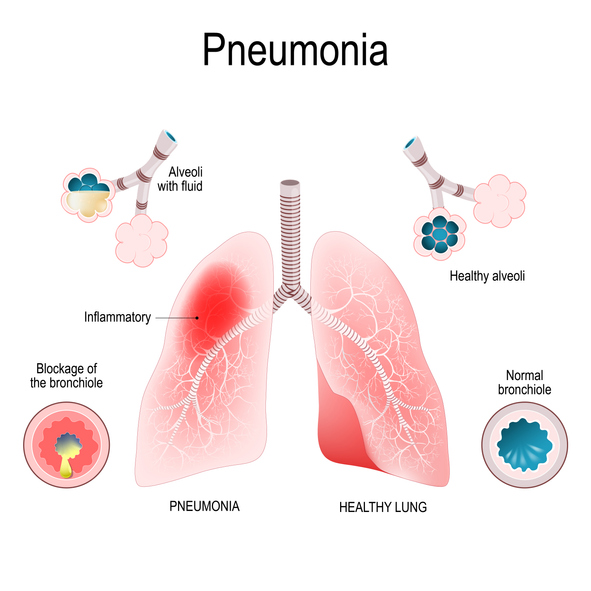

# (1) Importing the necessary libraries:-

In [1]:
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

from keras.src.legacy.preprocessing.image import ImageDataGenerator   # [Keras = 3]
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from keras.layers import SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np

In [2]:
from pathlib import Path
import glob2
from glob2 import glob
from os import *
import albumentations as A
import cv2
import os, random
from keras.preprocessing import image
import pandas as pd

from keras import backend as K

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

# (2) Loading the Dataset:-

In [4]:
dir_alldata = Path('chest_xray/')

In [5]:
train = 'chest_xray/train'
test =  'chest_xray/test'
val = 'chest_xray/val'

In [6]:
os.listdir('chest_xray')

['test', 'train', 'val']

# (3) Data Preprocessing:-

In [7]:
IMG_SIZE=200

In [8]:
#returns image path of a set of data, train, test and val;

def get_imgs_path(cat):
    PATH = dir_alldata / cat
    normal_path = PATH / 'NORMAL'
    pneumonia_path = PATH / 'PNEUMONIA'
    normal_imgs_path = normal_path.glob('*.jpeg')
    pneumonia_imgs_path = pneumonia_path.glob('*.jpeg')
    normal_imgs = [path for path in normal_imgs_path]
    pneumonia_imgs = [path for path in pneumonia_imgs_path]
    print('\n{} normal images in {} directory'.format(len(normal_imgs),cat))
    print('{} pneumonia images in {} directory\n'.format(len(pneumonia_imgs),cat))
    return normal_imgs,pneumonia_imgs

In [9]:
#return images and labels from given path;

def get_images(normal_imgs_path,pneumonia_imgs_path):
    normal_images=[]
    normal_labels=[]
    for image_path in normal_imgs_path:
        img = cv2.imread(str(image_path))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if img.shape[2]==1:
            img = np.dstack([img, img, img])
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        img  = img.astype(np.float32)
        normal_images.append(img)
        normal_labels.append(0)

    for image_path in pneumonia_imgs_path:
        img = cv2.imread(str(image_path))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if img.shape[2]==1:
            img = np.dstack([img, img, img])
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        img  = img.astype(np.float32)
        normal_images.append(img)
        normal_labels.append(1)
    return np.array(normal_images),np.array(normal_labels)

In [10]:
#Function for garbage collection
def clean(x):
    x=0
    gs.collect()

In [11]:
#Ready all 3 sets of data;

normal_train_path,pneumonia_train_path = get_imgs_path('train')
train_images,train_labels=get_images(normal_train_path,pneumonia_train_path)

print("Shape of train_images is {}".format(train_images.shape))
print("Shape of train_labels is {}".format(train_labels.shape))

normal_val_path,pneumonia_val_path = get_imgs_path('val')
val_images,val_labels=get_images(normal_val_path,pneumonia_val_path)

print("Shape of val_images is {}".format(val_images.shape))
print("Shape of val_labels is {}".format(val_labels.shape))

normal_test_path,pneumonia_test_path = get_imgs_path('test')
test_images,test_labels=get_images(normal_test_path,pneumonia_test_path)

print("Shape of test_images is {}".format(test_images.shape))
print("Shape of test_labels is {}".format(test_labels.shape))


1341 normal images in train directory
3875 pneumonia images in train directory

Shape of train_images is (5216, 200, 200, 3)
Shape of train_labels is (5216,)

8 normal images in val directory
8 pneumonia images in val directory

Shape of val_images is (16, 200, 200, 3)
Shape of val_labels is (16,)

234 normal images in test directory
390 pneumonia images in test directory

Shape of test_images is (624, 200, 200, 3)
Shape of test_labels is (624,)


# (4) Ploting Images (X-Ray Data):-

In [12]:
f = plt.figure(figsize=(20,20))
for i in range(1,17):
    ax = f.add_subplot(4,4,i)
    if i>=9:
        i += 1341
        ax.set_title('Pneumonia')
    else:
        ax.set_title('Normal')
    plt.imshow(train_images[i,:,:,:])
    ax.axis('off')

# (5) Data Modeling:-

### CNN Model;

In [13]:
#define focal loss function which works best for imbalanced classification
#Refer to original paper here https://arxiv.org/pdf/1708.02002.pdf
from keras import backend as K
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [14]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

In [15]:
img_size=200

In [16]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [17]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [18]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [19]:
model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [21]:
model.compile(loss= "binary_crossentropy",
              optimizer="adam", 
              metrics=["accuracy"])

### Exploratory data analysis;

In [22]:
# extract number of normal and pneumonia cases
DIR = "chest_xray/"
sets = ["test", "train", "val"]
all_pneumonia = []
all_normal = []

#create list of all images paths
for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob2.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob2.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 4273
Total Normal Images: 1583


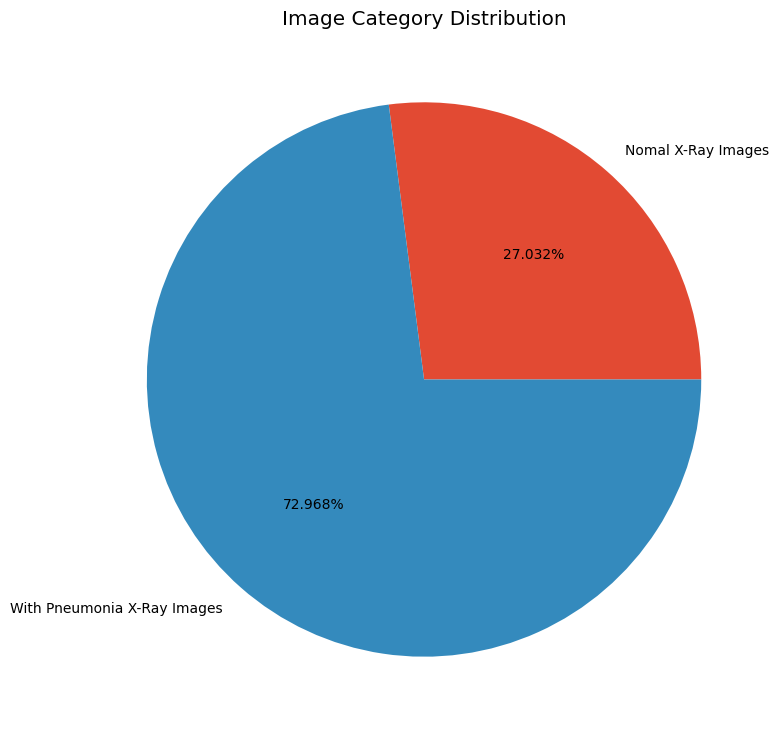

In [23]:
labels = ['Nomal X-Ray Images', 'With Pneumonia X-Ray Images']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.3f%%")
plt.title("Image Category Distribution")
plt.show()

In [24]:
from random import random, choice, shuffle

In [25]:
# Shuffle and Get some images into new list
shuffle(all_normal)
shuffle(all_pneumonia)
all_images = all_normal[:20] + all_pneumonia[:20]

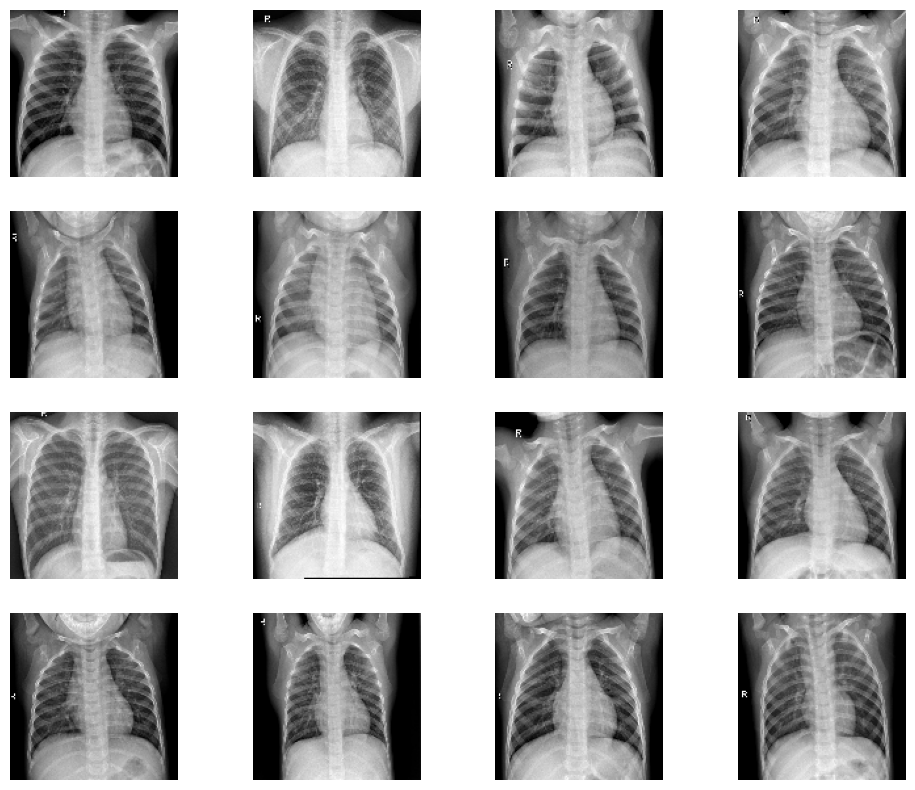

In [26]:
fig=plt.figure(figsize=(12, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(all_images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

In [27]:
#About training set 

DIR = "chest_xray/train"
all_train = []
norm = glob2.glob(os.path.join(DIR, "NORMAL/*.jpeg"))
pneu = glob2.glob(os.path.join(DIR, "PNEUMONIA/*.jpeg"))
all_train.extend(norm)
all_train.extend(pneu)

print(f"Total Pneumonia train Images: {len(pneu)}")
print(f"Total Normal train Images: {len(norm)}")

Total Pneumonia train Images: 3875
Total Normal train Images: 1341


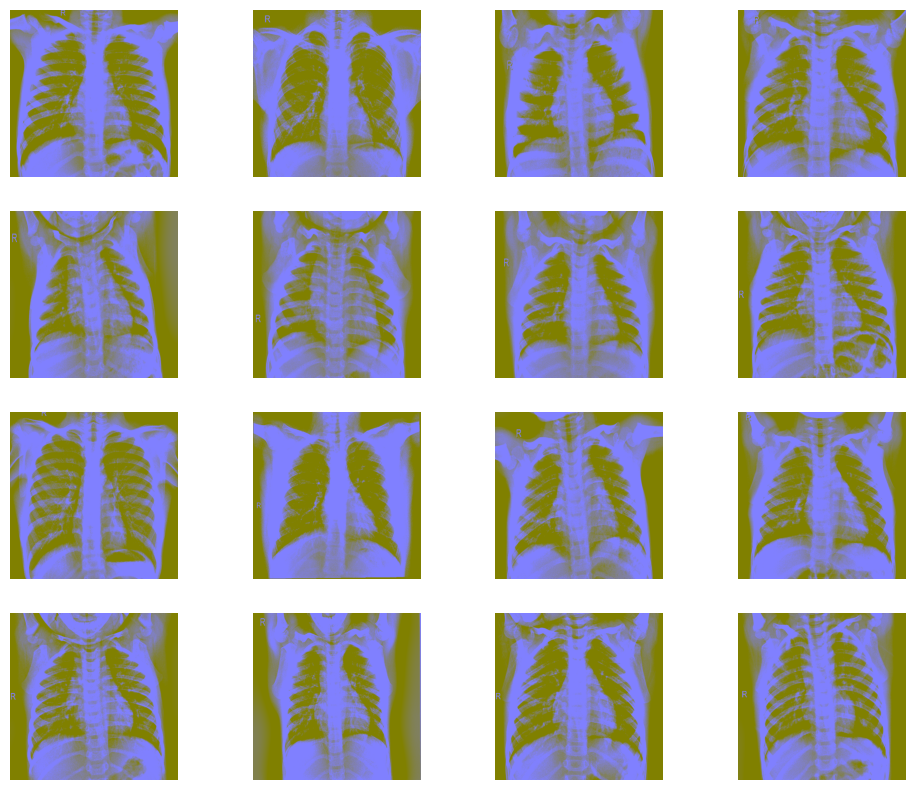

In [28]:
fig=plt.figure(figsize=(12, 10))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    img = cv2.imread(all_normal[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)                                     #HSV 
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)  # Gaussian Blur
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

In [29]:
from albumentations import *

In [30]:
#Function that returns augmented images and can plot them;

def plot_multiple_img(images,image_index,Albumentations, ncols, main_title="",plot=False):
    
    if plot==True: 
        fig, myaxes = plt.subplots(figsize=(20, 12), nrows=2, ncols=ncols, squeeze=False)
        fig.suptitle(main_title, fontsize = 30)
        fig.subplots_adjust(wspace=0.3)
        fig.subplots_adjust(hspace=0.3)
        img_matrix_list=[]  #Plot augmented image if we stet the boolean variable to TRUE
        
    image=cv2.imread(images[image_index])
    images=[]
    i=0
    for alb in (Albumentations.keys()): # iterate through Albumentations dictionnary {name of alb: alb}
        trans=Albumentations[alb]
        img=trans(image=image)['image']
        images.append(img)
        
        if plot==True: # plot albumentations if plot is activated
            myaxes[i // ncols][i % ncols].imshow(img)
            myaxes[i // ncols][i % ncols].set_title(alb, fontsize=15)
            i+=1
            
    plt.show()
    
    return(images) #return images with data augmentation

In [31]:
Albumentations = dict()

# transformation parameters
theta = 0.3
hrz_shift = 40
ver_shift = 40
size_low = 0.8
size_high = 1.3
cont_low = 0.7
cont_high = 1.3
rgb_limit=10

In [32]:
albs_keys=["RandomSunFlare","RandomFog",#"RandomBrightness",
               "RandomCrop","Rotate", "RGBShift","RandomSnow","HorizontalFlip", "VerticalFlip", 
                     #"RandomContrast",
             "HSV"]

In [33]:
albs_values = [A.RandomSunFlare(p=1), 
                      A.RandomFog(p=1), 
                      #A.RandomBrightness(p=1),
                      A.RandomCrop(p=1,height = 512, width = 512), 
                      A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1), 
                      A.RandomSnow(p=1),
                      A.HorizontalFlip(p=1), 
                      A.VerticalFlip(p=1), 
                      #A.RandomContrast(limit = 0.5,p = 1),
                      A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
                      #A.Cutout(p=1),
                      A.Transpose(p=1), 
                      #A.JpegCompression(p=1),
                      A.CoarseDropout(p=1),
                      #A.IAAAdditiveGaussianNoise(loc=0, scale=(2.5500000000000003, 12.75), per_channel=False, p=1),
                      #A.IAAAffine(scale=1.0, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', p=1),
                      #A.IAAAffine(rotate=90., p=1),
                      #A.IAAAffine(rotate=180., p=1)
              ]

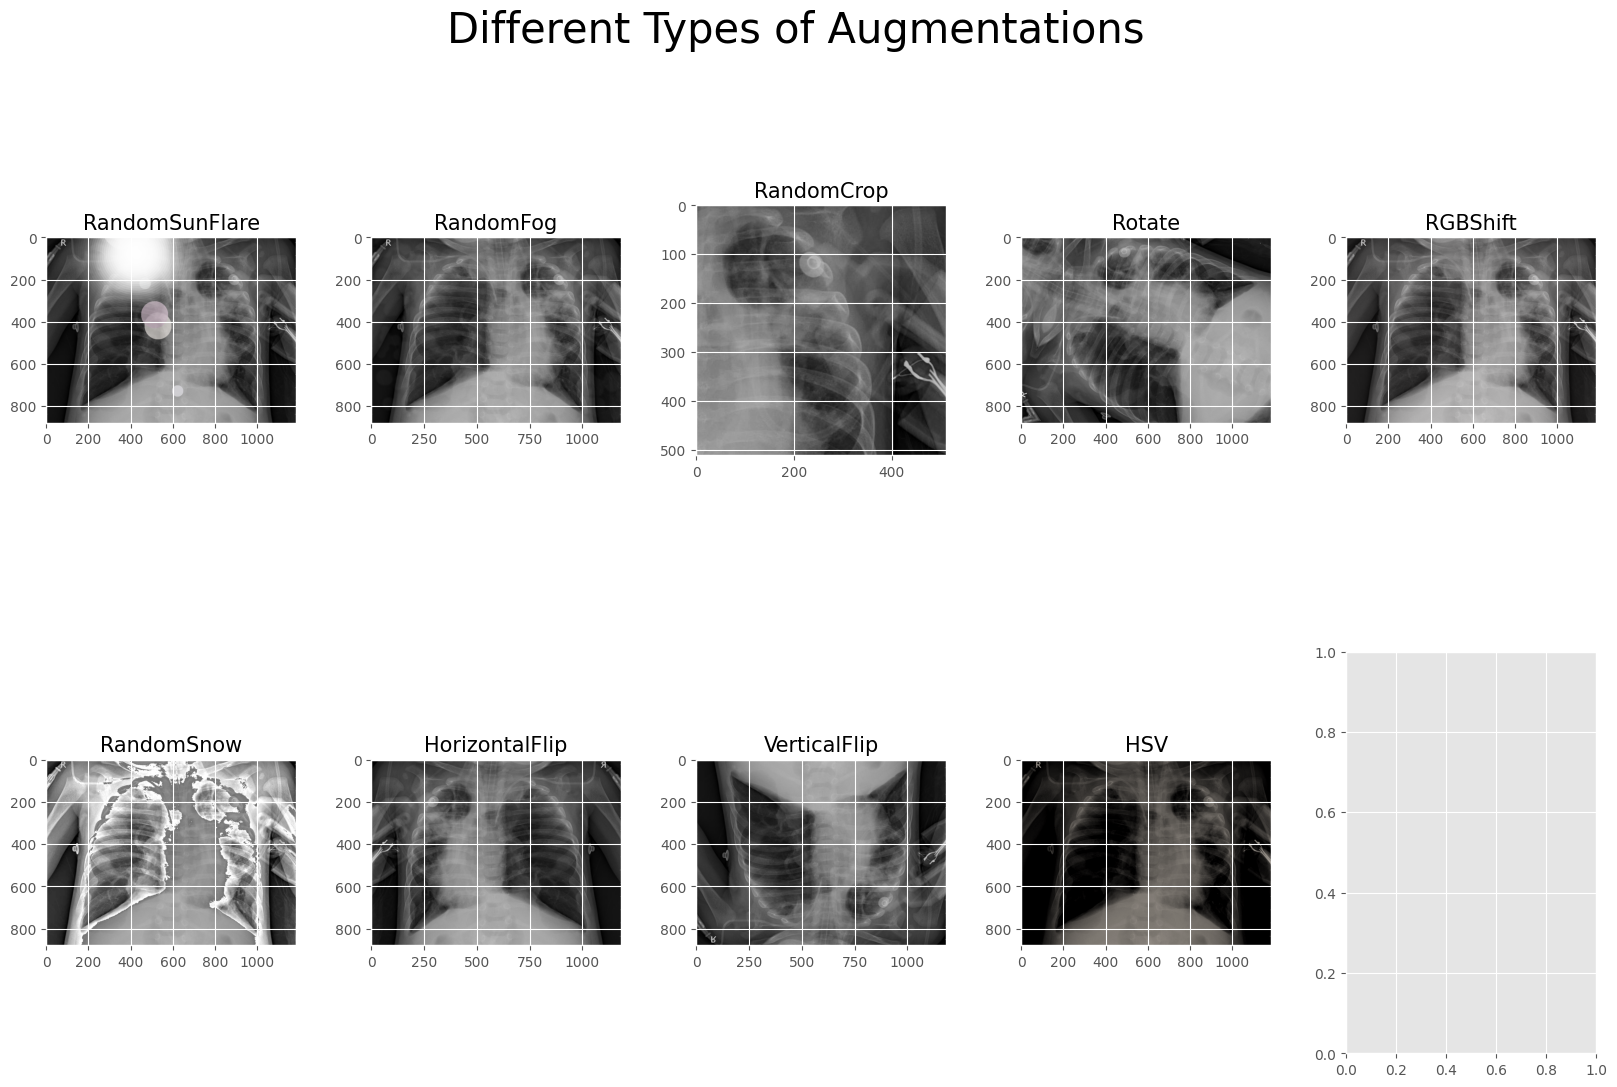

In [34]:
#plot the Albumentations
for i in range(len(albs_keys)):
    Albumentations[albs_keys[i]]=albs_values[i]
cc=plot_multiple_img(all_images,20,Albumentations, ncols = 5,main_title="Different Types of Augmentations",plot=True)

In [35]:
Albumentations = dict()

# transformations' parameters
theta = 0.3
size_low = 0.8
size_high = 1.3
bright_limit = 0.1
cont_limit = 0.1
rgb_limit=10

albs_keys=["RandomResizedCrop",
           "Rotate",
    "RandomBrightnessContrast",
           "HSV"]

albs_values = [ 
                A.RandomResizedCrop (p=1,height=256, width=256,scale=[0.95,0.95]),  #height after crop and resize#width after crop and resize#range of size of the origin size cropped
                A.Rotate(p=1, limit=theta), #thata rotation
                A.RandomBrightnessContrast(brightness_limit = [-bright_limit, bright_limit], 
                                           contrast_limit= [-cont_limit, cont_limit],p = 1), #factor range for changing brightness#contrast_limit:factor range for changing contrast
                A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)] #range for changing hue #range for changing saturation#range for changing value

In [36]:
for i in range(len(albs_keys)):
    Albumentations[albs_keys[i]]=albs_values[i]

In [37]:
cc=plot_multiple_img(
    all_images,15,
    Albumentations, 
    ncols =2 ,
    main_title="Different Types of Augmentations",
    plot=True)